In [1]:
import numpy as np
import pandas as pd

import matplotlib
import matplotlib.pyplot as plt

plt.style.use('seaborn')
%matplotlib inline

import os

# Работа с данными

## Иморт данных

In [2]:
data = pd.read_csv('bank-full.csv', sep=';')

In [3]:
data.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,58,management,married,tertiary,no,2143,yes,no,unknown,5,may,261,1,-1,0,unknown,no
1,44,technician,single,secondary,no,29,yes,no,unknown,5,may,151,1,-1,0,unknown,no
2,33,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,may,76,1,-1,0,unknown,no
3,47,blue-collar,married,unknown,no,1506,yes,no,unknown,5,may,92,1,-1,0,unknown,no
4,33,unknown,single,unknown,no,1,no,no,unknown,5,may,198,1,-1,0,unknown,no


In [4]:
data.shape

(45211, 17)

## Подготовка данных

### Чистка данных

Уберем данные с нулевой длительностью звонка:

In [5]:
data.drop(data[data.duration == 0].index, inplace=True)

### Кодировка строковых данных

Закодируем строковые данные стандартным образом:

In [6]:
col_names = [
    'job', 'marital', 'education', 'default', 'housing', 'loan', 'contact',
    'month', 'poutcome', 'y'
]

for col in col_names:
    data[col] = data[col].astype('category')
    data[col] = data[col].cat.codes

In [7]:
data.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,58,4,1,2,0,2143,1,0,2,5,8,261,1,-1,0,3,0
1,44,9,2,1,0,29,1,0,2,5,8,151,1,-1,0,3,0
2,33,2,1,1,0,2,1,1,2,5,8,76,1,-1,0,3,0
3,47,1,1,3,0,1506,1,0,2,5,8,92,1,-1,0,3,0
4,33,11,2,3,0,1,0,0,2,5,8,198,1,-1,0,3,0


In [8]:
data.shape

(45208, 17)

### Балансирование выборки

Разделим данные на предикторы и отклики:

In [9]:
X = data.iloc[:, :-1].values  
y = data.iloc[:, 16].values

Разделим данные на обучающее и тестовое множество:

In [10]:
from sklearn.model_selection import train_test_split

In [11]:
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=0.33,
                                                    random_state=123)

Сбалансирована ли выборка?

In [12]:
from collections import Counter

In [13]:
print(f"Training target statistics: {Counter(y_train)}")
print(f"Testing target statistics: {Counter(y_test)}")

Training target statistics: Counter({0: 26746, 1: 3543})
Testing target statistics: Counter({0: 13173, 1: 1746})


Выборка не сбалансирована: проведем **undersampling**:

In [14]:
from imblearn.under_sampling import RandomUnderSampler

In [15]:
under_sampler = RandomUnderSampler(random_state=123)
X_train, y_train = under_sampler.fit_resample(X_train, y_train)

print(f"Training target statistics: {Counter(y_train)}")
print(f"Testing target statistics: {Counter(y_test)}")

Training target statistics: Counter({0: 3543, 1: 3543})
Testing target statistics: Counter({0: 13173, 1: 1746})


### Стандартизация данных

In [16]:
from sklearn.preprocessing import StandardScaler 

In [17]:
scaler = StandardScaler()
scaler.fit(X_train)

X_train_2 = scaler.transform(X_train)
X_test_2 = scaler.transform(X_test)

# Классификация методом KNN

## Классификация

In [18]:
from sklearn.neighbors import KNeighborsClassifier  

In [19]:
classifier = KNeighborsClassifier(n_neighbors=5)
classifier.fit(X_train_2, y_train)

KNeighborsClassifier()

In [20]:
y_pred_train = classifier.predict(X_train_2)
y_pred_test = classifier.predict(X_test_2)

## Оценка классификации

### Матрица сопряженности

Построим таблицу сопряженности для обучающего и тестового множества:

In [21]:
from sklearn.metrics import confusion_matrix, f1_score, classification_report

In [22]:
print(u'Таблица сопряженности для обучающей выборки')
conf_mat = confusion_matrix(y_train, y_pred_train)
conf_mat_train = pd.DataFrame(conf_mat,
                              index=classifier.classes_,
                              columns=classifier.classes_)
conf_mat_train

Таблица сопряженности для обучающей выборки


,0,1
0,3078,465
1,586,2957


In [23]:
print(u'Таблица сопряженности для тестовой выборки')
conf_mat = confusion_matrix(y_test, y_pred_test)
conf_mat_test = pd.DataFrame(conf_mat,
                             index=classifier.classes_,
                             columns=classifier.classes_)
conf_mat_test

Таблица сопряженности для тестовой выборки


,0,1
0,10696,2477
1,470,1276


### Поиск оптимального k

Выберем метрику **f1-score** для оценки качесвта классификатора. Будем варьировать **k** и сравнивать **f1-score**.

In [24]:
error_rate = []
for i in range(1, 41):
    knn_res = KNeighborsClassifier(n_neighbors=i)
    knn_res.fit(X_train_2, y_train)
    pred_i = knn_res.predict(X_test_2)
    error_rate.append(f1_score(y_test, pred_i, average='weighted'))

Text(0, 0.5, 'F1')

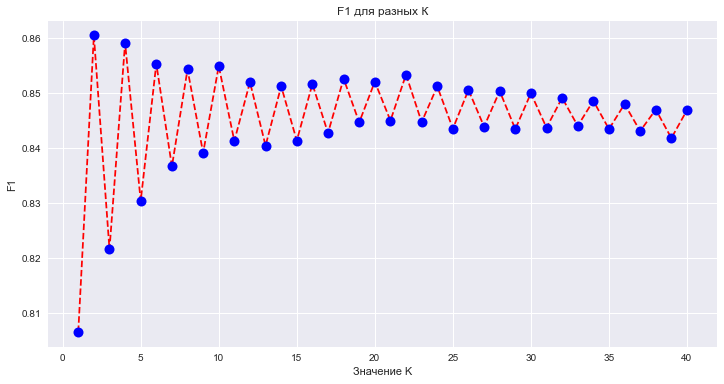

In [25]:
plt.figure(figsize=(12, 6))
plt.plot(range(1, 41),
         error_rate,
         color='red',
         linestyle='dashed',
         marker='o',
         markerfacecolor='blue',
         markersize=10)

plt.title(u'F1 для разных К')
plt.xlabel(u'Значение K')
plt.ylabel(u'F1')

Оптимальное значение **k = 2**

### Оценка итоговой модели при k=2

In [26]:
classifier = KNeighborsClassifier(n_neighbors=2)
classifier.fit(X_train_2, y_train)
y_pred_train = classifier.predict(X_train_2)
y_pred_test = classifier.predict(X_test_2)

Результаты на обучающем множестве:

In [27]:
print(classification_report(y_train, y_pred_train))

              precision    recall  f1-score   support

           0       0.79      1.00      0.88      3543
           1       1.00      0.74      0.85      3543

    accuracy                           0.87      7086
   macro avg       0.90      0.87      0.87      7086
weighted avg       0.90      0.87      0.87      7086



Результаты на тестовом множестве:

In [28]:
print(classification_report(y_test, y_pred_test))

              precision    recall  f1-score   support

           0       0.94      0.89      0.91     13173
           1       0.40      0.55      0.46      1746

    accuracy                           0.85     14919
   macro avg       0.67      0.72      0.69     14919
weighted avg       0.87      0.85      0.86     14919

